In [117]:
import time
import pandas as pd
import os
import numpy as np
import seaborn as sb
import inspect, re
import matplotlib.pyplot as plt
import missingno as msno
from yellowbrick.features import Rank2D
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

In [120]:
datapath='/Users/qisi_cao/Desktop/Kaggle Proj/useful'

In [121]:
train             = pd.read_csv(datapath+'/train.csv')
weather_train     = pd.read_csv(datapath+'/weather_train.csv')
building_metadata = pd.read_csv(datapath+'/building_metadata.csv')

In [124]:
building_metadata.info()

building_metadata.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')

Text(0.5, 1.0, 'percentatage of the missing value in each column')

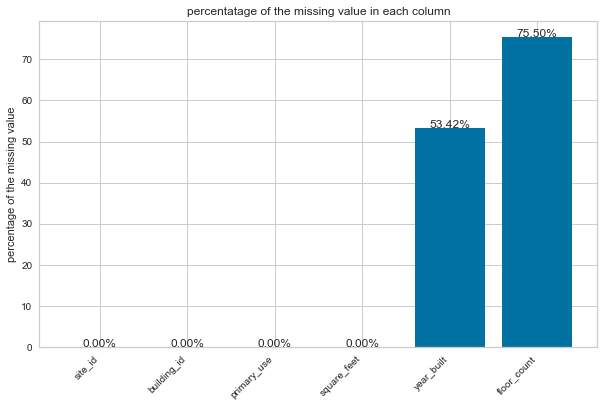

In [132]:
# Calculate the percentage of missing values for each column in building_metadata
# First calculate the percentage of the missing value out of all of the columns and use the barplot to get the visualization
col = list(building_metadata.columns)
missing_value = [building_metadata[c].isnull().sum() / len(building_metadata) * 100 for c in building_metadata.columns]
df_missing = pd.DataFrame({"columns": col, "missing_value": missing_value})
df_missing.set_index("columns", inplace=True, drop=True)
plt.figure(figsize=(10, 6))
plt.bar(df_missing.index, df_missing.missing_value)
for i, n in enumerate(list(df_missing.index)):
    plt.text(i, df_missing.loc[n]['missing_value'], s="{:0.2f}%".format(df_missing.loc[n]['missing_value']), horizontalalignment="center")
plt.xticks(rotation=45, horizontalalignment="right")
plt.ylabel("percentage of the missing value")
plt.title("percentatage of the missing value in each column")

Text(0.5, 1.0, 'percentatage of the missing value in each column')

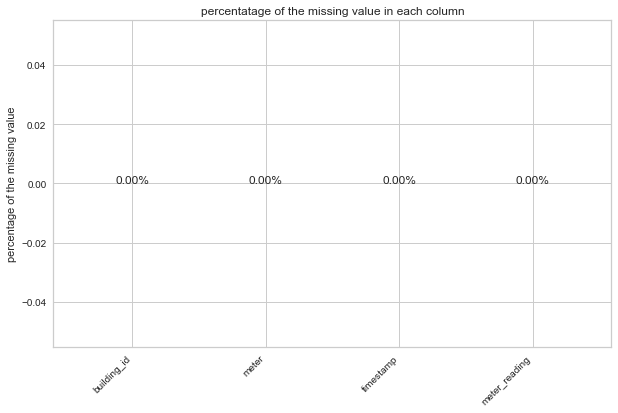

In [140]:
# Calculate the percentage of missing values for each column in train
# First calculate the percentage of the missing value out of all of the columns and use the barplot to get the visualization
col = list(train.columns)
missing_value = [train[c].isnull().sum() / len(train) * 100 for c in train.columns]
df_missing = pd.DataFrame({"columns": col, "missing_value": missing_value})
df_missing.set_index("columns", inplace=True, drop=True)
plt.figure(figsize=(10, 6))
plt.bar(df_missing.index, df_missing.missing_value)
for i, n in enumerate(list(df_missing.index)):
    plt.text(i, df_missing.loc[n]['missing_value'], s="{:0.2f}%".format(df_missing.loc[n]['missing_value']), horizontalalignment="center")
plt.xticks(rotation=45, horizontalalignment="right")
plt.ylabel("percentage of the missing value")
plt.title("percentatage of the missing value in each column")
# No missing value in this table

Text(0.5, 1.0, 'percentatage of the missing value in each column')

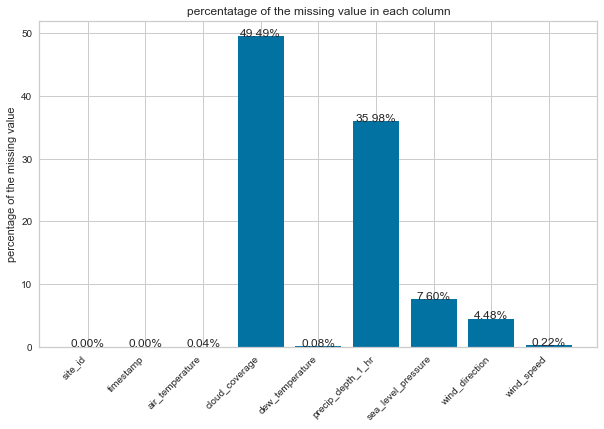

In [142]:
# Calculate the percentage of missing values for each column in weather_train
# First calculate the percentage of the missing value out of all of the columns and use the barplot to get the visualization
# The cloud_coverage has the highest as 49.49% of the missing value
col = list(weather_train.columns)
missing_value = [weather_train[c].isnull().sum() / len(weather_train) * 100 for c in weather_train.columns]
df_missing = pd.DataFrame({"columns": col, "missing_value": missing_value})
df_missing.set_index("columns", inplace=True, drop=True)
plt.figure(figsize=(10, 6))
plt.bar(df_missing.index, df_missing.missing_value)
for i, n in enumerate(list(df_missing.index)):
    plt.text(i, df_missing.loc[n]['missing_value'], s="{:0.2f}%".format(df_missing.loc[n]['missing_value']), horizontalalignment="center")
plt.xticks(rotation=45, horizontalalignment="right")
plt.ylabel("percentage of the missing value")
plt.title("percentatage of the missing value in each column")

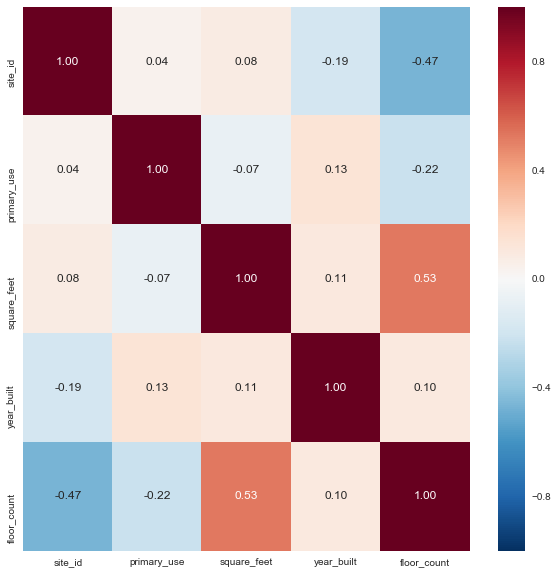

In [143]:
# Draw the heatmap based on how much two columns are correlated for table building_metadata
fig, ax = plt.subplots(figsize=(10, 10))
ax = sb.heatmap(building_metadata.corr(), fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1)

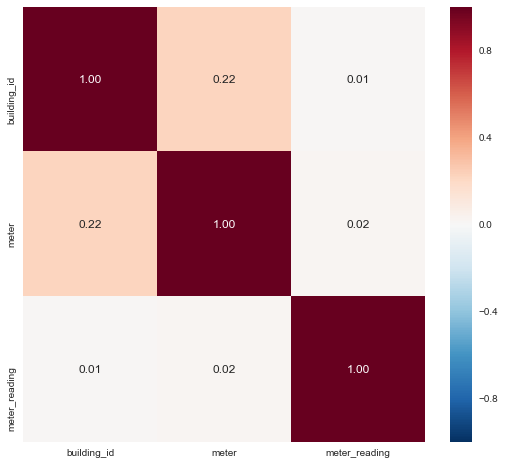

In [138]:
# Draw the heatmap based on how much two columns are correlated for table train
corrmat = train.corr() 
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1) 

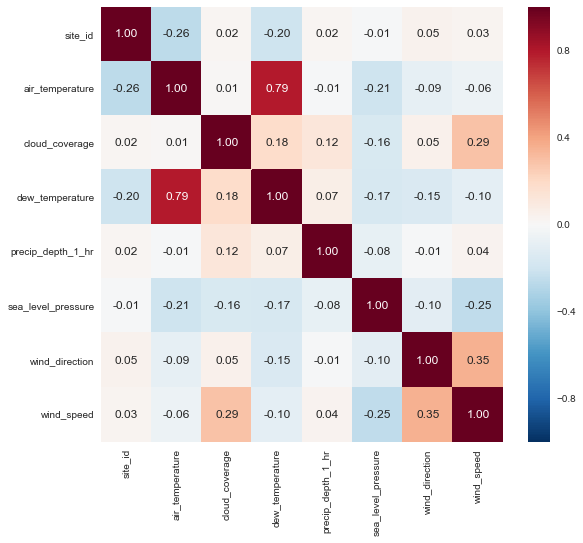

In [139]:
# Draw the heatmap based on how much two columns are correlated for table weather_train
corrmat = weather_train.corr() 
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1) 

Text(0.5, 1.0, 'Percentage of missing values for floor_count and year_built grouby site id')

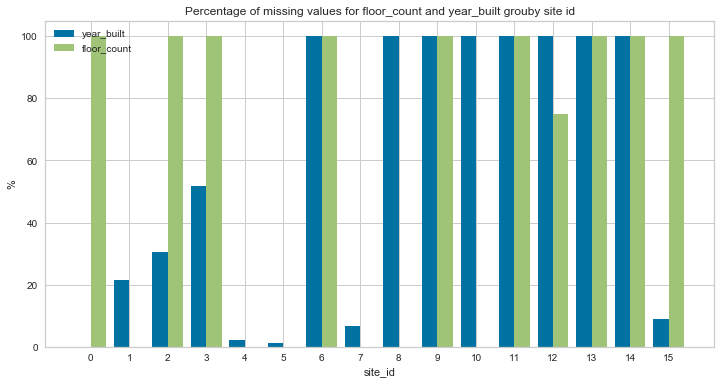

In [152]:
# First group by all of the columns based on site id for building_metadata
# Get all the missing values for each site id and calculate each percentage and plot

df_building = building_metadata[["site_id", "primary_use", "year_built", "floor_count"]].groupby("site_id").count()
df_building["%year_built"] = df_building[["primary_use", "year_built"]].apply(lambda x: round((x["primary_use"] - x["year_built"]) / x["primary_use"] * 100, 2), axis=1)
df_building["%floor_count"] = df_building[["primary_use", "floor_count"]].apply(lambda x: round((x["primary_use"] - x["floor_count"]) / x["primary_use"] * 100, 2), axis=1)

plt.figure(figsize=(12, 6))
plt.bar(df_building.index - 0.2, df_building["%year_built"], width=0.4, label="year_built")
plt.bar(df_building.index +  0.2, df_building["%floor_count"], width=0.4, label="floor_count")
plt.xticks(range(len(df_building)))
plt.xlabel("site_id")
plt.ylabel("%")
plt.legend()
plt.title("Percentage of missing values for floor_count and year_built grouby site id")

Text(0.5, 1.0, 'Percentage of missing values for floor_count and year_built grouby site id')

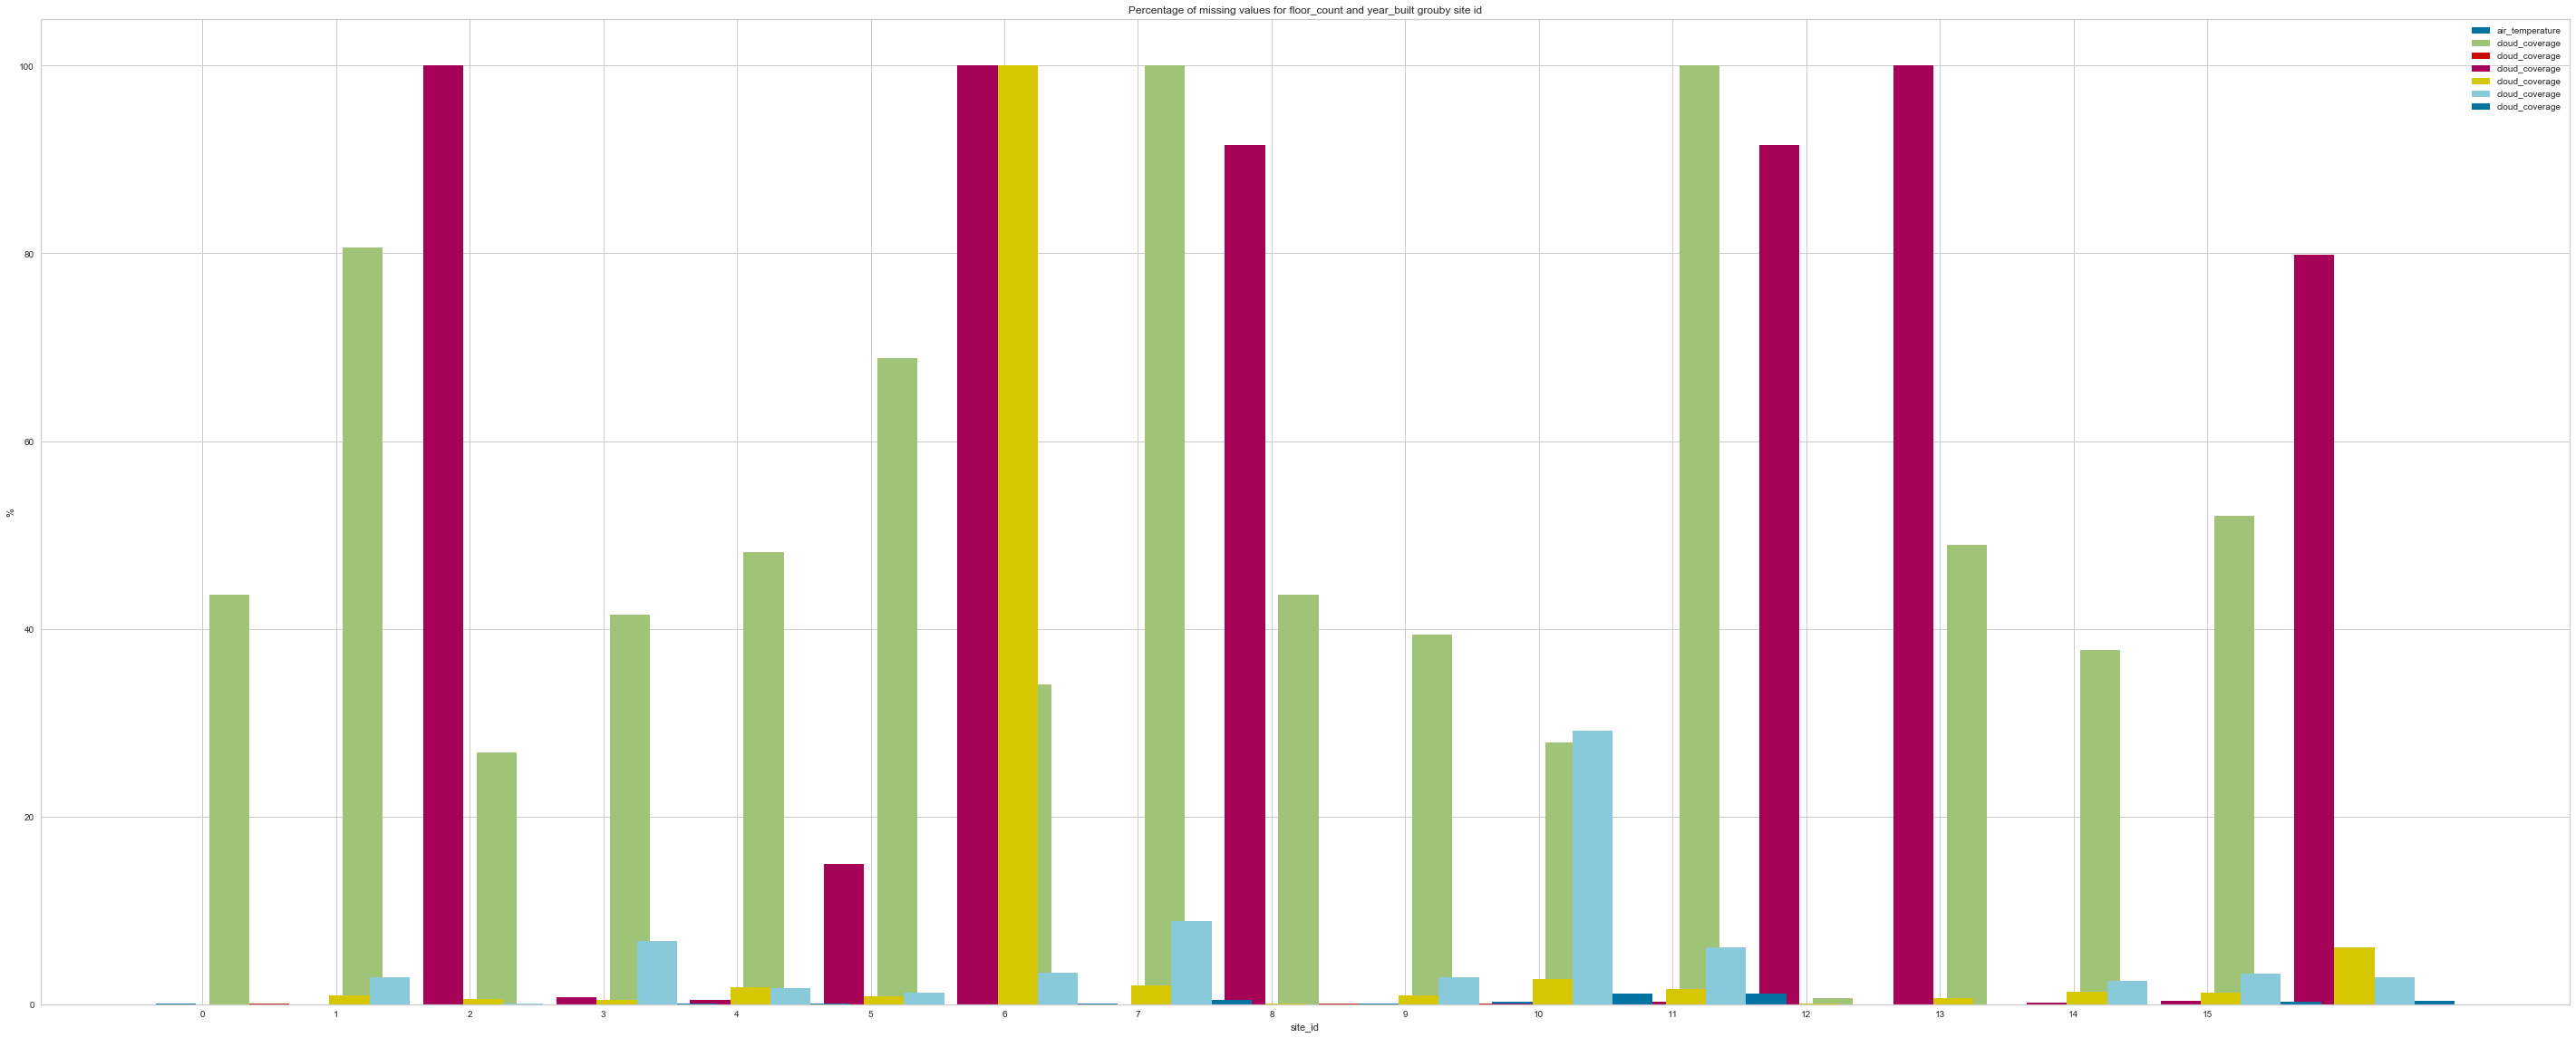

In [157]:
# First group by all of the columns based on site id for building_metadata
# Get all the missing values for each site id and calculate each percentage and plot

df_weather = weather_train[["site_id", "timestamp", "air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]].groupby("site_id").count()
df_weather["%air_temperature"] = df_weather[["timestamp", "air_temperature"]].apply(lambda x: round((x["timestamp"] - x["air_temperature"]) / x["timestamp"] * 100, 2), axis=1)
df_weather["%cloud_coverage"] = df_weather[["timestamp","cloud_coverage"]].apply(lambda x: round((x["timestamp"] - x["cloud_coverage"]) / x["timestamp"] * 100, 2), axis=1)
df_weather["%dew_temperature"] = df_weather[["timestamp", "dew_temperature"]].apply(lambda x: round((x["timestamp"] - x["dew_temperature"]) / x["timestamp"] * 100, 2), axis=1)
df_weather["%precip_depth_1_hr"] = df_weather[["timestamp", "precip_depth_1_hr"]].apply(lambda x: round((x["timestamp"] - x["precip_depth_1_hr"]) / x["timestamp"] * 100, 2), axis=1)
df_weather["%sea_level_pressure"] = df_weather[["timestamp", "sea_level_pressure"]].apply(lambda x: round((x["timestamp"] - x["sea_level_pressure"]) / x["timestamp"] * 100, 2), axis=1)
df_weather["%wind_direction"] = df_weather[["timestamp", "wind_direction"]].apply(lambda x: round((x["timestamp"] - x["wind_direction"]) / x["timestamp"] * 100, 2), axis=1)
df_weather["%wind_speed"] = df_weather[["timestamp", "wind_speed"]].apply(lambda x: round((x["timestamp"] - x["wind_speed"]) / x["timestamp"] * 100, 2), axis=1)


plt.figure(figsize=(50, 20))
plt.bar(df_weather.index - 0.2, df_weather["%air_temperature"], width=0.3, label="air_temperature")
plt.bar(df_weather.index +  0.2, df_weather["%cloud_coverage"], width=0.3, label="cloud_coverage")
plt.bar(df_weather.index +  0.5, df_weather["%dew_temperature"], width=0.3, label="cloud_coverage")
plt.bar(df_weather.index +  0.8, df_weather["%precip_depth_1_hr"], width=0.3, label="cloud_coverage")
plt.bar(df_weather.index +  1.1, df_weather["%sea_level_pressure"], width=0.3, label="cloud_coverage")
plt.bar(df_weather.index +  1.4, df_weather["%wind_direction"], width=0.3, label="cloud_coverage")
plt.bar(df_weather.index +  1.7, df_weather["%wind_speed"], width=0.3, label="cloud_coverage")
plt.xticks(range(len(df_weather)))
plt.xlabel("site_id")
plt.ylabel("%")
plt.legend()
plt.title("Percentage of missing values grouby site id")

([<matplotlib.patches.Wedge at 0x144a8a748>,
 [Text(-0.38849017388074375, 1.24059477058309, 'electricity'),
  Text(-0.3396392142533405, -1.0462529350694187, 'chilledwater'),
  Text(0.7554155646910904, -0.7995919738356815, 'steam'),
  Text(1.0788460633073647, -0.21468854577317814, 'hotwater')],
 [Text(-0.2390708762343038, 0.7634429357434399, '59.7%'),
  Text(-0.1852577532290948, -0.5706834191287739, '20.7%'),
  Text(0.41204485346786746, -0.4361410766376444, '13.4%'),
  Text(0.5884614890767443, -0.11710284314900625, '6.3%')])

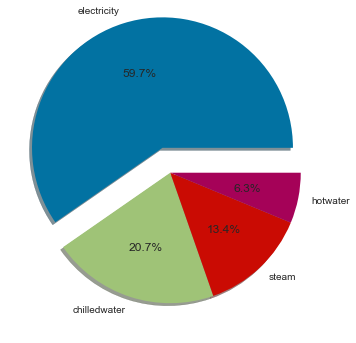

In [159]:
# Group by the meter type and get percentage of each type's in the buildings
df_train = train[["building_id", "meter"]].groupby("meter").count()
plt.figure(figsize=(6, 6))
plt.pie(df_train.building_id, explode=(0.2, 0, 0, 0), 
        labels=["electricity", "chilledwater", "steam", "hotwater"], 
        shadow=True,
        autopct='%1.1f%%')

### Ignore This one, not right

Text(0, 0.5, 'Nombre de batiment')

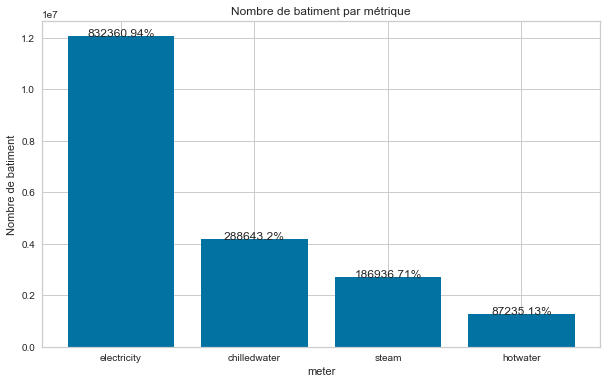

In [167]:
plt.figure(figsize=(10, 6)) 
plt.bar(df_train.index, df_train.building_id)
plt.xticks(range(4), ["electricity", "chilledwater", "steam", "hotwater"])
for i, row in df.iterrows():
    pct = round(row["building_id"] / len(building_metadata) * 100, 2)
    plt.text(i, row["building_id"], s="{}%".format(pct), horizontalalignment="center")
plt.title("Nombre de batiment par métrique")
plt.xlabel("meter")
plt.ylabel("Nombre de batiment")


In [168]:
len(building_metadata)

1449